필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(scb_yearly))  # type-dict
print(scb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
scb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
scb_yearly_df13 = pd.DataFrame()

for item in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[item]])

In [10]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


In [12]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

In [13]:
scb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01h,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02h,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03h,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04h,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9


유량 데이터 추가하기

In [14]:
scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['연월일시'] = scb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [18]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [19]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(scb_flow_yearly_hour_df.__len__())
print(scb_yearly_df13.__len__())

84393
82257


In [21]:
scb_yearly_df13['연월일시'] = scb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

In [23]:
scb_data = scb_data[:82257]

In [24]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11   상류수위(EL.m)  82231 non-null  float64
 12   하류수위(EL.m)  82231 non-null  float64
 13   유입량(㎥/s)    82231 non-null  float64
 14   방류량(㎥/s)    82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [25]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

In [26]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11  상류수위(EL.m)   82231 non-null  float64
 12  하류수위(EL.m)   82231 non-null  float64
 13  유입량(㎥/s)     82231 non-null  float64
 14  방류량(㎥/s)     82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [27]:
scb_data = scb_data.loc[:, list(scb_data.columns)[:3]  + list(scb_data.columns)[4:5] + list(scb_data.columns)[6:-5] + list(scb_data.columns)[-4:-3] + list(scb_data.columns)[-1:]]

In [28]:
scb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [29]:
scb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
전기전도도 μS/cm    17733
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
상류수위(EL.m)        26
방류량(㎥/s)          26
dtype: int64

In [30]:
scb_data.isnull().sum() /len(scb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

In [31]:
len(scb_data)

82257

시간데이터 추가

In [32]:
scb_df = scb_data.copy()

In [33]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [34]:
col_c = list(scb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [35]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [36]:
for i in range(1, 49):
    scb_df[str(i) + 'shift 총인'] = scb_df['총인 mg/L'].shift(i)

In [37]:
len(scb_df)

82257

In [38]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 총인',
       '2shift 총인', '3shift 총인', '4shift 총인', '5shift 총인', '6shift 총인',
       '7shift 총인', '8shift 총인', '9shift 총인', '10shift 총인', '11shift 총인',
       '12shift 총인', '13shift 총인', '14shift 총인', '15shift 총인', '16shift 총인',
       '17shift 총인', '18shift 총인', '19shift 총인', '20shift 총인', '21shift 총인',
       '22shift 총인', '23shift 총인', '24shift 총인', '25shift 총인', '26shift 총인',
       '27shift 총인', '28shift 총인', '29shift 총인', '30shift 총인', '31shift 총인',
       '32shift 총인', '33shift 총인', '34shift 총인', '35shift 총인', '36shift 총인',
       '37shift 총인', '38shift 총인', '39shift 총인', '40shift 총인', '41shift 총인',
       '42shift 총인', '43shift 총인', '44shift 총인', '45shift 총인', '46shift 총인',
       '47shift 총인', '48shift 총인'],
      dtype='object')

In [39]:
len(scb_df)

82257

결측치 보간법

In [40]:
from datetime import datetime

In [41]:
scb_df = scb_df.copy()

In [42]:
scb_df['측정일/월'] = scb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [43]:
scb_df = scb_df.copy().set_index('측정일/월').interpolate(method='time')

In [44]:
scb_df = scb_df.dropna()

In [45]:
scb_df.__len__()

80106

In [46]:
scb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 총인', '2shift 총인',
       '3shift 총인', '4shift 총인', '5shift 총인', '6shift 총인', '7shift 총인',
       '8shift 총인', '9shift 총인', '10shift 총인', '11shift 총인', '12shift 총인',
       '13shift 총인', '14shift 총인', '15shift 총인', '16shift 총인', '17shift 총인',
       '18shift 총인', '19shift 총인', '20shift 총인', '21shift 총인', '22shift 총인',
       '23shift 총인', '24shift 총인', '25shift 총인', '26shift 총인', '27shift 총인',
       '28shift 총인', '29shift 총인', '30shift 총인', '31shift 총인', '32shift 총인',
       '33shift 총인', '34shift 총인', '35shift 총인', '36shift 총인', '37shift 총인',
       '38shift 총인', '39shift 총인', '40shift 총인', '41shift 총인', '42shift 총인',
       '43shift 총인', '44shift 총인', '45shift 총인', '46shift 총인', '47shift 총인',
       '48shift 총인'],
      dtype='object')

In [47]:
scb_df.head()

,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),1shift 총인,...,39shift 총인,40shift 총인,41shift 총인,42shift 총인,43shift 총인,44shift 총인,45shift 총인,46shift 총인,47shift 총인,48shift 총인
측정일/월,,,,,,,,,,,,,,,,,,,,,
2013-03-31 16:00:00,용봉,14.0,326.0,3.4,6.847,0.102,41.0,7.52,12.426667,0.102,...,0.099,0.101,0.103,0.104,0.105,0.106,0.107,0.106,0.105,0.104
2013-03-31 17:00:00,용봉,14.0,329.0,3.4,6.967,0.102,42.4,7.52,12.426667,0.102,...,0.101,0.099,0.101,0.103,0.104,0.105,0.106,0.107,0.106,0.105
2013-03-31 18:00:00,용봉,13.6,328.0,3.4,7.094,0.101,40.1,7.52,12.390000,0.102,...,0.102,0.101,0.099,0.101,0.103,0.104,0.105,0.106,0.107,0.106
2013-03-31 19:00:00,용봉,13.4,330.0,3.4,7.146,0.099,39.7,7.52,12.383333,0.101,...,0.101,0.102,0.101,0.099,0.101,0.103,0.104,0.105,0.106,0.107
2013-03-31 20:00:00,용봉,13.3,333.0,3.4,7.038,0.098,39.4,7.52,12.370000,0.099,...,0.100,0.101,0.102,0.101,0.099,0.101,0.103,0.104,0.105,0.106


In [48]:
col = list(scb_df.columns[1:])
#print(col)

In [49]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
#print(col_v)

피처 정규화 없이

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [51]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [52]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [53]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [54]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.938519,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.936878,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.935734,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.934588,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.924428,5


In [55]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [56]:
estimator = gb_grid.best_estimator_

In [57]:
pred = estimator.predict(X_test)

In [58]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.19 수온 ℃
0.25 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.08 총질소 mg/L
0.04 총인 mg/L
0.13 상류수위(EL.m)
0.11 방류량(㎥/s)
0.0 1shift 총인
0.01 2shift 총인
0.0 3shift 총인
0.0 4shift 총인
0.0 5shift 총인
0.0 6shift 총인
0.0 7shift 총인
0.0 8shift 총인
0.0 9shift 총인
0.0 10shift 총인
0.0 11shift 총인
0.0 12shift 총인
0.0 13shift 총인
0.0 14shift 총인
0.0 15shift 총인
0.0 16shift 총인
0.01 17shift 총인
0.0 18shift 총인
0.0 19shift 총인
0.0 20shift 총인
0.0 21shift 총인
0.0 22shift 총인
0.0 23shift 총인
0.0 24shift 총인
0.0 25shift 총인
0.0 26shift 총인
0.0 27shift 총인
0.0 28shift 총인
0.0 29shift 총인
0.0 30shift 총인
0.0 31shift 총인
0.0 32shift 총인
0.0 33shift 총인
0.0 34shift 총인
0.0 35shift 총인
0.0 36shift 총인
0.0 37shift 총인
0.0 38shift 총인
0.0 39shift 총인
0.0 40shift 총인
0.0 41shift 총인
0.0 42shift 총인
0.0 43shift 총인
0.0 44shift 총인
0.0 45shift 총인
0.0 46shift 총인
0.01 47shift 총인
0.01 48shift 총인


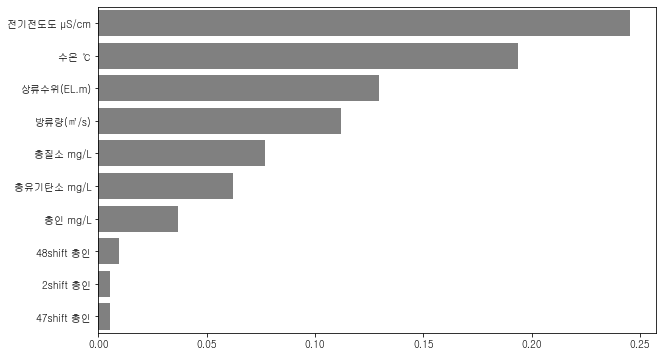

In [59]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [60]:
feature_series[:10]

전기전도도 μS/cm    0.245172
수온 ℃           0.193612
상류수위(EL.m)     0.129511
방류량(㎥/s)       0.112016
총질소 mg/L       0.077025
총유기탄소 mg/L     0.061977
총인 mg/L        0.037010
48shift 총인     0.009483
2shift 총인      0.005419
47shift 총인     0.005393
dtype: float64

In [61]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9592860229878329


피처 정규화

In [62]:
scaler = StandardScaler()
scaler.fit(scb_df.loc[:, col_v])
scb_scaled = scaler.transform(scb_df.loc[:, col_v])

scb_df_scaled = pd.DataFrame(data = scb_scaled, columns = col_v)

In [63]:
scb_df_scaled.head()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift 총인,2shift 총인,3shift 총인,...,39shift 총인,40shift 총인,41shift 총인,42shift 총인,43shift 총인,44shift 총인,45shift 총인,46shift 총인,47shift 총인,48shift 총인
0,-0.460123,-0.204436,-1.066592,0.701736,-0.404844,0.712847,-0.173164,-0.404847,-0.419518,-0.463542,...,-0.448897,-0.419550,-0.390203,-0.375532,-0.360860,-0.346187,-0.331515,-0.346191,-0.360857,-0.375534
1,-0.460123,-0.170395,-1.066592,0.762211,-0.404844,0.712847,-0.173164,-0.404847,-0.404844,-0.419519,...,-0.419548,-0.448899,-0.419552,-0.390206,-0.375534,-0.360862,-0.346189,-0.331516,-0.346182,-0.360859
2,-0.512399,-0.181742,-1.066592,0.826214,-0.419518,0.712847,-0.173485,-0.404847,-0.404844,-0.404845,...,-0.404873,-0.419550,-0.448901,-0.419555,-0.390209,-0.375536,-0.360864,-0.346191,-0.331507,-0.346185
3,-0.538537,-0.159048,-1.066592,0.852420,-0.448867,0.712847,-0.173544,-0.419522,-0.404844,-0.404845,...,-0.419548,-0.404875,-0.419552,-0.448904,-0.419558,-0.390211,-0.375539,-0.360866,-0.346182,-0.331510
4,-0.551606,-0.125007,-1.066592,0.797992,-0.463541,0.712847,-0.173661,-0.448870,-0.419518,-0.404845,...,-0.434222,-0.419550,-0.404877,-0.419555,-0.448907,-0.419560,-0.390213,-0.375540,-0.360857,-0.346185


In [64]:
X_trains, X_tests, y_trains, y_tests = train_test_split(scb_df_scaled.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [65]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [66]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [67]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [68]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.938324,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.936667,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.935868,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.935141,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.924488,5


In [69]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [70]:
estimators = gb_grids.best_estimator_

In [71]:
preds = estimators.predict(X_tests)

In [72]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.19 수온 ℃
0.25 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.08 총질소 mg/L
0.04 총인 mg/L
0.13 상류수위(EL.m)
0.11 방류량(㎥/s)
0.0 1shift 총인
0.01 2shift 총인
0.0 3shift 총인
0.0 4shift 총인
0.0 5shift 총인
0.0 6shift 총인
0.0 7shift 총인
0.0 8shift 총인
0.0 9shift 총인
0.0 10shift 총인
0.0 11shift 총인
0.0 12shift 총인
0.0 13shift 총인
0.0 14shift 총인
0.0 15shift 총인
0.0 16shift 총인
0.01 17shift 총인
0.0 18shift 총인
0.0 19shift 총인
0.0 20shift 총인
0.0 21shift 총인
0.0 22shift 총인
0.0 23shift 총인
0.0 24shift 총인
0.0 25shift 총인
0.0 26shift 총인
0.0 27shift 총인
0.0 28shift 총인
0.0 29shift 총인
0.0 30shift 총인
0.0 31shift 총인
0.0 32shift 총인
0.0 33shift 총인
0.0 34shift 총인
0.0 35shift 총인
0.0 36shift 총인
0.0 37shift 총인
0.0 38shift 총인
0.0 39shift 총인
0.0 40shift 총인
0.0 41shift 총인
0.0 42shift 총인
0.0 43shift 총인
0.0 44shift 총인
0.0 45shift 총인
0.0 46shift 총인
0.01 47shift 총인
0.01 48shift 총인


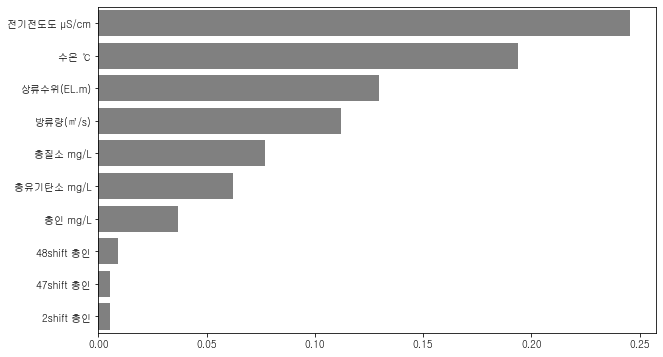

In [73]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [74]:
feature_seriess[:10]

전기전도도 μS/cm    0.245305
수온 ℃           0.193663
상류수위(EL.m)     0.129439
방류량(㎥/s)       0.111987
총질소 mg/L       0.076887
총유기탄소 mg/L     0.061992
총인 mg/L        0.037012
48shift 총인     0.009237
47shift 총인     0.005431
2shift 총인      0.005355
dtype: float64

In [75]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9596594208001599
